In [186]:
import glob
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [187]:
path = "Datos"
 
Archivos = glob.glob(path + "/*.xlsx")
ListaExcel = []
 
for Archivo in Archivos:
    ListaExcel.append(pd.read_excel(Archivo))
 
sismos = pd.DataFrame() 
for excel in ListaExcel:
    sismos = sismos.append(
      excel, ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13820\2472829785.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sismos = sismos.append(


In [188]:
sismos.head()

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,MAGNITUD Mw,DEPARTAMENTO,MUNICIPIO,# FASES,RMS (Seg),GAP (grados),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),ESTADO
0,1993-06-01,01:32:55,6.795,-73.052,150.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,8.7,10.0,8.6,Revisado
1,1993-06-01,03:08:28,6.790,-73.053,152.5,3.0,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,10.3,9.8,8.9,Revisado
2,1993-06-01,10:13:18,6.839,-73.105,152.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.5,321.0,13.2,12.3,11.2,Revisado
3,1993-06-01,10:34:45,6.894,-73.171,150.0,2.9,NaN,SANTANDER,BETULIA,4,0.3,308.0,8.6,9.5,8.4,Revisado
4,1993-06-01,15:31:24,6.754,-73.058,150.0,4.4,NaN,SANTANDER,JORDAN,9,0.5,308.0,8.9,8.1,7.6,Revisado


In [189]:
sismos.dtypes

FECHA                      object
HORA_UTC                   object
LATITUD (grados)          float64
LONGITUD (grados)         float64
PROFUNDIDAD (Km)          float64
MAGNITUD Ml               float64
MAGNITUD Mw               float64
DEPARTAMENTO               object
MUNICIPIO                  object
# FASES                     int64
RMS (Seg)                 float64
GAP (grados)              float64
ERROR LATITUD (Km)        float64
ERROR LONGITUD (Km)       float64
ERROR PROFUNDIDAD (Km)    float64
ESTADO                     object
dtype: object

In [190]:
sismos["FechaCompleta"] = pd.to_datetime(sismos.FECHA+" "+ sismos.HORA_UTC)

In [191]:
Departamento = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/MGN_DPTO_POLITICO.shp')

Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.astype("category")
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
rename_dic = {"ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA":"ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA"}
Departamento.DPTO_CNMBR = Departamento.DPTO_CNMBR.replace(rename_dic).astype("category")
sismos.DEPARTAMENTO = sismos.DEPARTAMENTO.astype("category")
sismos = pd.merge(sismos, Departamento[['DPTO_CNMBR',"DPTO_NAREA"]], left_on = 'DEPARTAMENTO', right_on='DPTO_CNMBR', how="left")

In [192]:
sismos_shape = gpd.GeoDataFrame(sismos,geometry = gpd.points_from_xy(sismos["LONGITUD (grados)"], sismos["LATITUD (grados)"]))
sismos_shape.crs = 'epsg:4326'

unidades_crono = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/UnidaddesCrono.shp')
fallas = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/Fallas.shp')
Volcanes = gpd.read_file('D:/Programación_Python/Python-ArcPy/Datos/Volcanes.shp')

unidades_crono = unidades_crono.to_crs("epsg:4326")
fallas = fallas.to_crs("epsg:4326")
Volcanes = Volcanes.to_crs("epsg:4326")



In [193]:
sismos = sismos_shape.sjoin(unidades_crono, how = "left")
sismos_geo = gpd.GeoSeries(sismos_shape.geometry)
sismos_fallas = fallas.sindex.nearest(sismos_geo, return_all=False,return_distance= True)
sismos_volcanes = Volcanes.sindex.nearest(sismos_geo, return_all=False, return_distance= True)

In [194]:
sismos["id_falla"] = sismos_fallas[0][1]
sismos["Disfalla"] = sismos_fallas[1]*111.320
sismos["id_volcan"] = sismos_volcanes[0][1]
sismos["Disvolcan"] = sismos_volcanes[1]*111.320

In [195]:
sismos = pd.merge(sismos, Volcanes, left_on = 'id_volcan', right_index=True, how="left")
sismos = pd.merge(sismos, fallas, left_on = 'id_falla', right_index=True, how="left")

In [196]:
sismos.NombreVolc.unique()

array(['Volcán San Diego', 'Volcán Paramillo de Santa Rosa',
       'Volcán Cumbal', 'Volcán Romeral', None, 'Volcán Nevado del Ruiz',
       'Volcán La Palma', 'Volcán Cerro Negro', 'Volcán Sotará',
       'Volcán Nevado del Huila', 'Volcán Guacharacos',
       'Volcán El Escondido', 'Volcán Azufral', 'Volcán Cerro Machín',
       'Volcán Galeras', 'Volcán Cerro Bravo', 'Volcán Chiles',
       'Maar de Yerbabuena', 'Volcán Las Ánimas', 'Volcán Morazurco',
       'Volcán Puracé', 'Volcán Cutunga', 'Volcán Nevado del Tolima',
       'Volcan Santa Leticia', 'Volcán Sibundoy',
       'Complejo Volcánico de Doña Juana', 'Volcán Laguna del Buey',
       'Volcán El Morro', 'Volcán El Pensil', 'Volcán Merenberg',
       'Volcán Petacas', 'Volcán Cerro Crespo',
       'Volcán Paramillo del Quindío', 'Volcán El Dorado',
       'Volcán Paramillo del Cisne', 'Volcán Nevado de Santa Isabel',
       'Volcán Shaka', 'Volcán Bordoncillo', 'Volcán Mujundinoy',
       'Volcán Campanero', 'Volcán Calamb

In [197]:
sismos["Año"] = sismos.FechaCompleta.dt.year
sismos["Mes"] = sismos.FechaCompleta.dt.month
sismos["Dia"] = sismos.FechaCompleta.dt.weekday
sismos["hora"] = sismos.FechaCompleta.dt.hour

In [198]:
sismos = sismos[(sismos.Año >=1994) &(sismos.Año <=2017)]

sismos.Edad = sismos.Edad.str.replace("?","")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13820\3028008039.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sismos.Edad = sismos.Edad.str.replace("?","")


In [199]:
sismos.Edad.unique()

array(['Jurásico', 'Cuaternario', 'Ordovícico-Llandovery',
       'Paleoceno-Eoceno', 'Jurásico Inferior-Jurásico Medio',
       'Langhiano-Serravaliano', 'Valanginiano-Albiano',
       'Jurásico Superior', 'Aptiano-Cenomaniano', 'Berriasiano', nan,
       'Prídoli-Devónico Inferior', 'Esténico-Tónico', 'Triásico',
       'Eoceno', 'Turoniano-Maastrichtiano', 'Plioceno',
       'Rupeliano-Langhiano', 'Cretácico Inferior',
       'Berriasiano-Cenomaniano', 'Berriasiano-Aptiano',
       'Cretácico Superior', 'Holoceno', 'Plioceno-Pleistoceno',
       'Pleistoceno', 'Cenomaniano-Maastrichtiano',
       'Valanginiano-Cenomaniano', 'Cámbrico-Ordovícico',
       'Albiano-Maastrichtiano', 'Cenomaniano-Santoniano',
       'Valanginiano-Aptiano', 'Mioceno', 'Paleoceno',
       'Oligoceno-Mioceno', 'Rupeliano-Burdigaliano',
       'Serravaliano-Mesiniano', 'Tortoniano-Mesiniano',
       'Barremiano-Cenomaniano', 'Bartoniano-Chatiano', 'Oligoceno',
       'Bartoniano-Rupeliano', 'Paleozoico', 'Ap

In [200]:
edades = {'Jurásico' : 173.15,
'Cuaternario' : 1.29,
'Ordovícico-Llandovery' : 459.4,
'Paleoceno-Eoceno' : 49.95,
'Jurásico Inferior-Jurásico Medio' : 182.4,
'Langhiano-Serravaliano' : 13.8,
'Valanginiano-Albiano' : 120.15,
'Jurásico Superior' : 154.25,
'Aptiano-Cenomaniano' : 107.65,
'Berriasiano' : 142.4,
'Prídoli-Devónico Inferior' : 408.45,
'Esténico-Tónico' : 960,
'Triásico' : 226.601,
'Eoceno' : 44.95,
'Turoniano-Maastrichtiano' : 83,
'Plioceno' : 3.955,
'Rupeliano-Langhiano' : 23.86,
'Cretácico Inferior' : 125,
'Berriasiano-Cenomaniano' : 119.45,
'Berriasiano-Aptiano' : 129,
'Cretácico Superior' : 83.25,
'Holoceno' : 0.00585,
'Plioceno-Pleistoceno' : 2.67235,
'Pleistoceno' : 1.29585,
'Cenomaniano-Maastrichtiano' : 83.25,
'Valanginiano-Cenomaniano' : 120.15,
'Cámbrico-Ordovícico' : 491.3,
'Albiano-Maastrichtiano' : 89.5,
'Cenomaniano-Santoniano' : 94.3,
'Valanginiano-Aptiano' : 106.75,
'Mioceno' : 14.18165,
'Paleoceno' : 61,
'Oligoceno-Mioceno' : 19.615,
'Rupeliano-Burdigaliano' : 24.935,
'Serravaliano-Mesiniano' : 9.5765,
'Tortoniano-Mesiniano' : 8.48,
'Barremiano-Cenomaniano' : 111.65,
'Bartoniano-Chatiano' : 32.115,
'Oligoceno' : 28.465,
'Bartoniano-Rupeliano' : 34.51,
'Paleozoico' : 394.951,
'Aptiano-Maastrichtiano' : 93.7,
'Serravaliano-Tortoniano' : 10.53,
'Aptiano-Albiano' : 110.95,
'Campaniano-Paleoceno' : 69.8,
'Albiano-Cenomaniano' : 103.45,
'Aquitaniano-Tortoniano' : 15.135,
'Bartoniano-Priaboniano' : 37.55,
'Langhiano-Tortoniano' : 11.605,
'Devónico-Carbonífero' : 359.05,
'Devónico Medio-Devónico Superior' : 326.1,
'Mesiniano-Zancleano' : 5.423,
'Cenomaniano-Campaniano' : 86.3,
'Pérmico' : 275.401,
'Aquitaniano-Burdigaliano' : 19.5,
'Thanetiano-Ypresiano' : 53.5,
'Maastrichtiano-Paleoceno' : 64.05,
'Eoceno-Aquitaniano' : 38.22,
'Burdigaliano-Langhiano' : 17.13,
'Valanginiano' : 136.2,
'Campaniano-Maastrichtiano' : 74.8,
'Maastrichtiano' : 69.05,
'Barremiano-Albiano' : 114.95,
'Carbonífero' : 328.9,
'Berriasiano-Barremiano' : 133.2,
'Pensilvánico-Pérmico' : 243.17,
'Ordovícico Inferior' : 477.7,
'Lutetiano-Bartoniano' : 44.5,
'Albiano-Campaniano' : 92.55,
'Pérmico-Triásico' : 250.1,
'Jurásico Medio-Jurásico Superior' : 159.55,
'Ordovícico' : 464.6,
'Jurásico Inferior' : 187.7,
'Pos-Triásico' : 187.7,
'Triásico Superior' : 219.15,
'Berriasiano-Valanginiano' : 138.8,
'Albiano' : 106.75}

In [201]:
def map_values(x):
    return edades.get(x, x)

sismos["EdadMillAños"] = sismos.Edad.apply(map_values)

    

In [202]:
sismos = sismos.loc[sismos["EdadMillAños"].notna()]

In [203]:
columns_dict = {"LATITUD (grados)":"Latitud",
                "LONGITUD (grados)":"Longitud",
                "PROFUNDIDAD (Km)":"Profundidad",
                "MAGNITUD Ml":"Magnitud_ML",
                "DEPARTAMENTO":"Departamento",
                "MUNICIPIO":"Municipio",
                "# FASES":"Fases",
                "DPTO_NAREA":"Area_Departamento"
               }
sismos = sismos.rename(columns=columns_dict)

In [204]:
sismos = sismos.drop(columns=['FECHA','HORA_UTC','MAGNITUD Mw','RMS (Seg)', 'GAP (grados)','ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)',
       'ESTADO', 'DPTO_CNMBR','ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)', 'ESTADO','geometry_x','index_right', 'N_CartaCo', 'SHAPE_Leng_x', 'SHAPE_Area', 
       'id_falla','id_volcan','VolcanID','Latitud', 'Longitud', 'Comentario_y', 'URL','geometry_y','Tipo', 'Comentario', 'SHAPE_Leng_y','geometry','Comentario_x'])

In [222]:
round(sismos.describe(),2)

,Profundidad,Magnitud_ML,Fases,Area_Departamento,Disfalla,Disvolcan,AlturaSobr,Año,Mes,Dia,hora,EdadMillAños
count,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00,162930.00
mean,103.57,2.07,7.39,32016.88,4.17,212.86,1285.55,2009.54,6.60,3.02,10.43,151.95
std,59.29,0.69,4.57,12555.90,8.08,87.45,1139.96,6.36,3.53,2.02,6.80,152.80
min,0.00,0.10,0.00,1933.57,0.00,0.17,0.00,1994.00,1.00,0.00,0.00,0.01
25%,32.10,1.60,5.00,30561.51,1.19,167.12,850.00,2005.00,3.00,1.00,5.00,83.25
50%,139.90,2.00,6.00,30561.51,2.63,238.11,850.00,2011.00,7.00,3.00,9.00,120.15
75%,147.30,2.50,8.00,30561.51,4.72,247.45,850.00,2015.00,10.00,5.00,16.00,154.25
max,700.00,6.80,72.00,109497.05,140.57,828.26,5364.00,2017.00,12.00,6.00,23.00,960.00


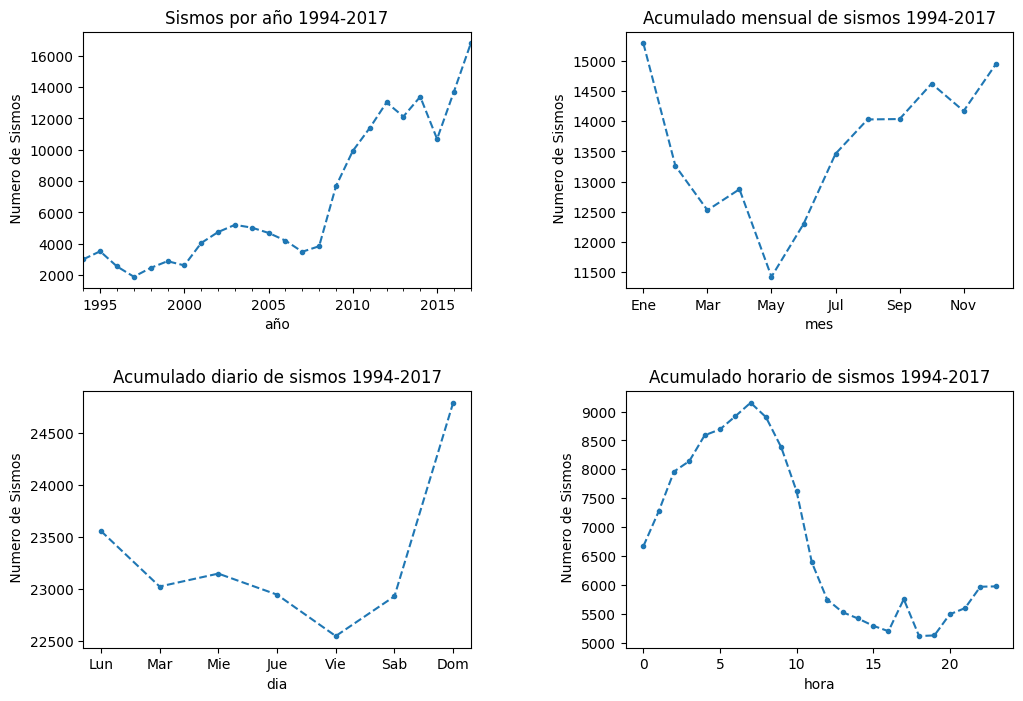

In [218]:
sismos_xmes = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'M')
sismos_xmes = sismos_xmes.value_counts().sort_index()

sismos_xaño = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'Y')
sismos_xaño = sismos_xaño.value_counts().sort_index()


sismosmes = sismos.Mes.value_counts().sort_index()
sismosmes.index = ['Ene','Feb','Mar','Abr','May','Jun', 'Jul','Ago','Sep','Oct','Nov','Dec']

sismosdia = sismos.Dia.value_counts().sort_index()
sismosdia.index = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']

sismoshora = sismos.hora.value_counts().sort_index()


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

#sismos_xmes.plot(marker='.', ls = '--', title = 'Sismos por Mes 1994-2017', ax=ax2).set(title='Points vs. Assists', xlabel = "ssss")
sismos_xaño.plot(marker='.', ls = '--', title = 'Sismos por año 1994-2017', ax=ax1).set(xlabel = "año", ylabel = " Numero de Sismos")
sismosmes.plot(marker='.', ls = '--', title = 'Acumulado mensual de sismos 1994-2017', ax=ax2).set(xlabel = "mes", ylabel = " Numero de Sismos")
sismosdia.plot(marker='.', ls = '--', title = 'Acumulado diario de sismos 1994-2017', ax=ax3).set(xlabel = "dia", ylabel = " Numero de Sismos")
sismoshora.plot(marker='.', ls = '--', title = 'Acumulado horario de sismos 1994-2017', ax=ax4).set(xlabel = "hora", ylabel = " Numero de Sismos")
#sismoshora.plot(marker='.', ls = '--', title = 'Acumulado horarios de sismos 1994-2017', ax=ax6).set(xlabel = "hora", ylabel = " Numero de Sismos")

plt.subplots_adjust(wspace=0.4,hspace=0.4)

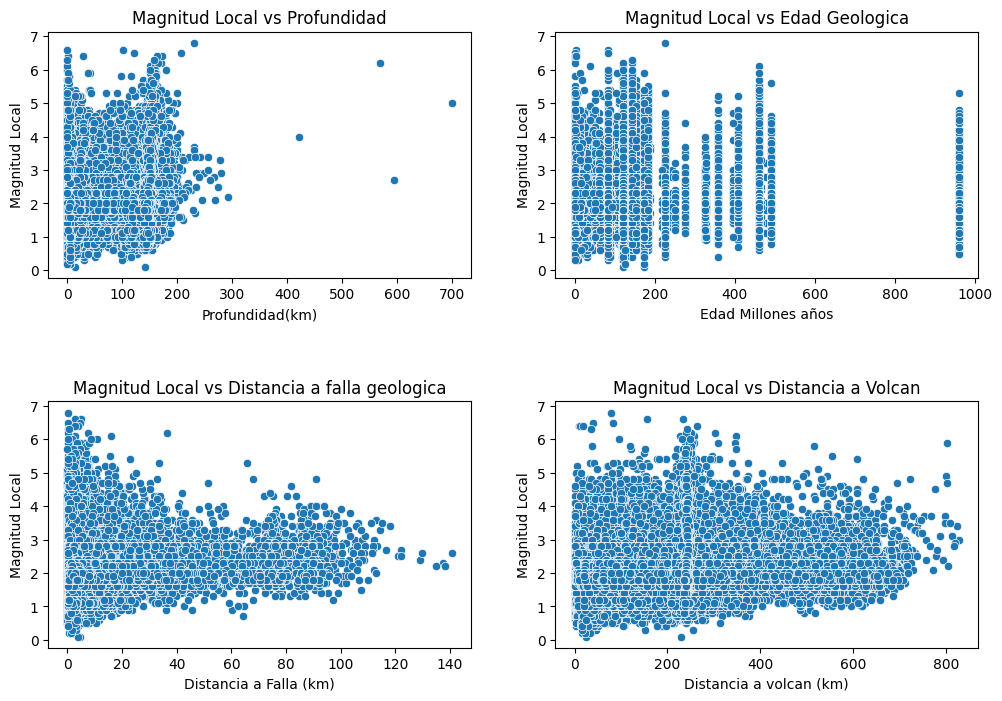

In [220]:


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.scatterplot( data=sismos, x=sismos.Profundidad, y=sismos.Magnitud_ML, ax = ax1).set(title='Magnitud Local vs Profundidad', xlabel = "Profundidad(km)", ylabel = 'Magnitud Local')
sns.scatterplot( data=sismos, x=sismos.EdadMillAños, y=sismos.Magnitud_ML, ax = ax2).set(title='Magnitud Local vs Edad Geologica', xlabel = "Edad Millones años", ylabel = 'Magnitud Local')
sns.scatterplot( data=sismos, x=sismos.Disfalla, y=sismos.Magnitud_ML, ax = ax3).set(title='Magnitud Local vs Distancia a falla geologica', xlabel = "Distancia a Falla (km)", ylabel = 'Magnitud Local')
sns.scatterplot( data=sismos, x=sismos.Disvolcan, y=sismos.Magnitud_ML, ax = ax4).set(title='Magnitud Local vs Distancia a Volcan', xlabel = "Distancia a volcan (km)", ylabel = 'Magnitud Local')



plt.subplots_adjust(wspace=0.2,hspace=0.5)


<AxesSubplot: xlabel='Año', ylabel='Mes'>

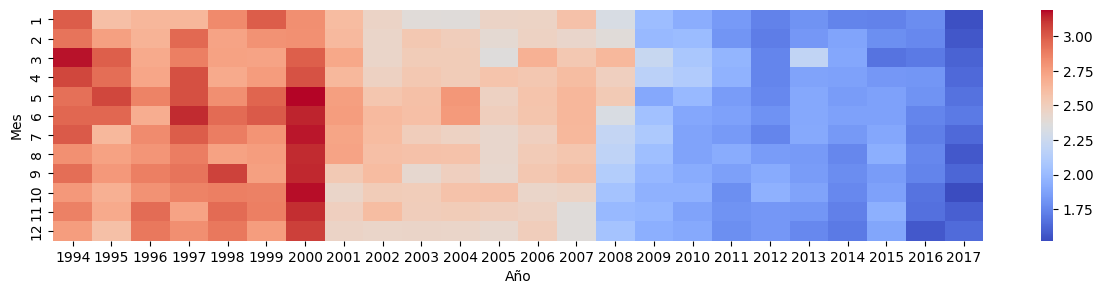

In [208]:
pivoted_df = pd.pivot_table(data=sismos, index="Mes", columns="Año", values="Magnitud_ML")

plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df, cmap="coolwarm") # cmap defines the color palette

<AxesSubplot: >

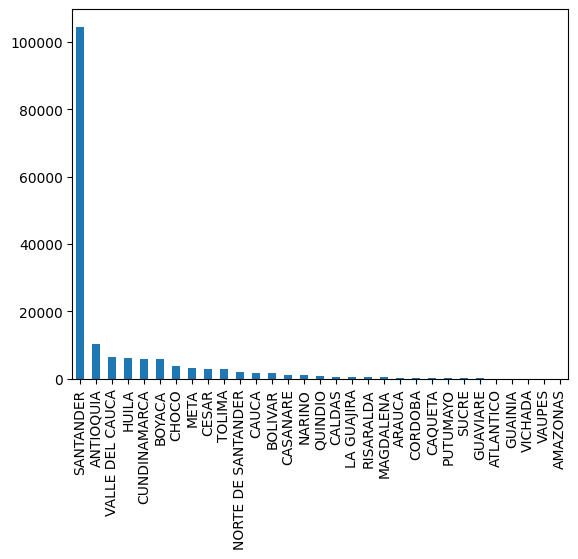

In [239]:


SismosDpto  = sismos.Departamento.value_counts()
SismosDpto.plot.bar()


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))



plt.subplots_adjust(wspace=0.2,hspace=0.5)


In [247]:
sispro = pd.DataFrame((pd.DataFrame(SismosDpto)/ len(sismos.index))*100)
sispro

,Departamento
SANTANDER,64.125698
ANTIOQUIA,6.400295
VALLE DEL CAUCA,3.921930
HUILA,3.736574
CUNDINAMARCA,3.547536
BOYACA,3.522985
CHOCO,2.244522
META,1.884245
CESAR,1.747376
TOLIMA,1.701958


In [ ]:
sismosdpto = sismos.groupby(["Departamento"])["Magnitud_ML"].max()

<AxesSubplot: xlabel='Departamento'>

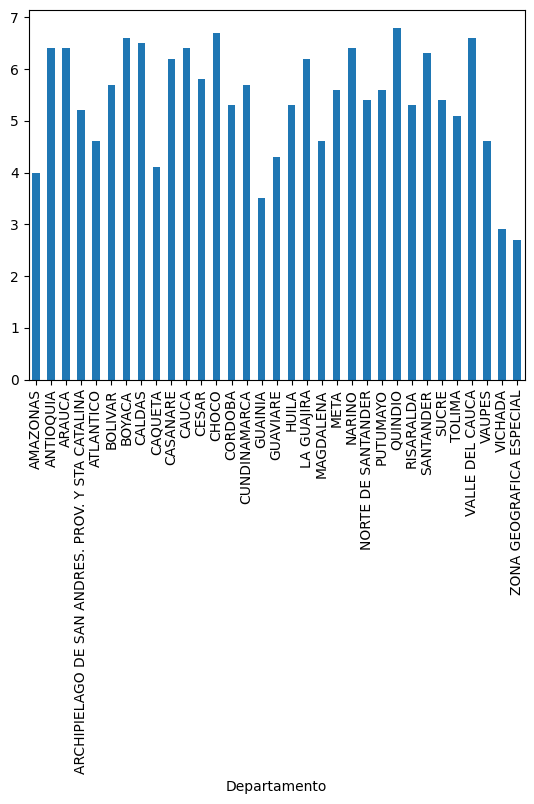

In [ ]:
sismosdpto.plot.bar()

In [ ]:
sismosaño = sismos.groupby(["Departamento", "Año"])["Magnitud_ML"].max()
sismosaño

Departamento              Año 
AMAZONAS                  1998    4.0
                          2012    3.2
ANTIOQUIA                 1994    6.4
                          1995    5.1
                          1996    5.4
                                 ... 
VICHADA                   1998    2.8
                          2010    2.9
                          2013    2.5
                          2014    2.5
ZONA GEOGRAFICA ESPECIAL  2004    2.7
Name: Magnitud_ML, Length: 650, dtype: float64

<AxesSubplot: xlabel='Departamento', ylabel='Año'>

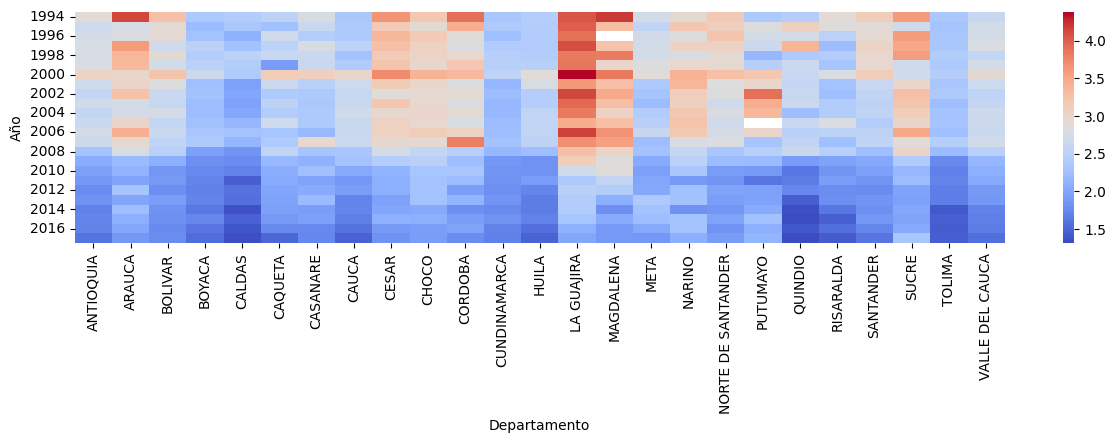

In [ ]:
pivoted_df2 = pd.pivot_table(data=sismos, index="Año", columns="Departamento", values="Magnitud_ML")
pivoted_df2 = pivoted_df2.drop(columns=['ARCHIPIELAGO DE SAN ANDRES. PROV. Y STA CATALINA', 'GUAINIA', 'VAUPES','VICHADA', 'ZONA GEOGRAFICA ESPECIAL', 'AMAZONAS', 'GUAVIARE', 'ATLANTICO'])

plt.figure(figsize=(15, 3)) # We can set the size using matplotlib
sns.heatmap(pivoted_df2, cmap="coolwarm") # cmap defines the color palet

In [ ]:
sismos

,Profundidad,Magnitud_ML,Departamento,Municipio,Fases,FechaCompleta,Area_Departamento,SimboloUC,Descripcio,Edad,UGIntegrad,Disfalla,Disvolcan,NombreVolc,AlturaSobr,NombreFall,Año,Mes,Dia,hora
1136,158.6,3.7,SANTANDER,CEPITA,8,1994-01-01 00:06:37,30561.514953,J-Pi,Granodioritas que varían de sienogranitos a to...,Jurásico,Granito de Pescadero,0.021758,2.335882,Volcán San Diego,850.0,Falla del Río Perchiquez,1994,1,5,0
1137,166.6,4.1,SANTANDER,GUACA,12,1994-01-01 08:17:30,30561.514953,J-Pi,Granodioritas que varían de sienogranitos a to...,Jurásico,Granito de Pescadero,0.017281,2.387977,Volcán San Diego,850.0,Falla del Río Perchiquez,1994,1,5,8
1138,35.2,3.6,ANTIOQUIA,MURINDO,13,1994-01-01 20:25:54,62808.629597,Q-al,Depósitos aluviales y de llanuras aluviales,Cuaternario,None,0.143934,2.120475,Volcán Romeral,3858.0,None,1994,1,5,20
1139,150.0,3.0,SANTANDER,SAN_ANDRES,12,1994-01-02 01:55:17,30561.514953,OS1-Mbg,"Filitas, esquistos, cuarcitas, pizarras, metac...",Ordovícico-Llandovery,Formación Silgará,0.010589,2.364454,Volcán San Diego,850.0,None,1994,1,6,1
1140,34.3,2.9,ANTIOQUIA,URRAO,13,1994-01-02 03:25:27,62808.629597,E1E2-VCm,Basaltos; brechas; aglomerados y tobas interca...,Paleoceno-Eoceno,Complejo Santa Cecilia-La Equis,0.066595,1.610929,Volcán Romeral,3858.0,None,1994,1,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175908,140.1,1.8,SANTANDER,LOS_SANTOS,13,2017-12-31 10:27:49,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.029086,2.135963,Volcán San Diego,850.0,Falla de Aratoca,2017,12,6,10
175909,141.4,1.8,SANTANDER,LOS_SANTOS,10,2017-12-31 14:19:03,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.038211,2.123106,Volcán San Diego,850.0,Falla de Suárez,2017,12,6,14
175910,144.8,1.8,SANTANDER,LOS_SANTOS,10,2017-12-31 14:35:51,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.038302,2.119558,Volcán San Diego,850.0,Falla de Suárez,2017,12,6,14
175911,140.0,1.8,SANTANDER,ZAPATOCA,7,2017-12-31 15:23:12,30561.514953,b2b6-Sm,"Shales con yeso, cherts, calizas y arenitas.",Valanginiano-Albiano,None,0.030152,2.116932,Volcán San Diego,850.0,Falla de Suárez,2017,12,6,15
